In [1]:
import os
import math
import time
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

# ---------------------------
# 0. Parameters & Output Dir
# ---------------------------
dataset_path = "/Users/book_kuno/Desktop/Final/ML_System/datasets/2018.csv"
run_name     = "2dcnn_run1-0_5pct"
model_name   = "2dcnn"
sample_fraction = 0.1
csv_name     = os.path.splitext(os.path.basename(dataset_path))[0]
output_folder = os.path.join("Outputs", csv_name, model_name, run_name)
os.makedirs(output_folder, exist_ok=True)
print("Outputs will go to:", output_folder)

Outputs will go to: Outputs/2018/2dcnn/2dcnn_run1-0_5pct


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = models.to(device)

Using device: cpu


AttributeError: module 'torchvision.models' has no attribute 'to'

In [ ]:
# ---------------------------
# 1. Load & Sample Data
# ---------------------------
data = pd.read_csv(dataset_path, low_memory=False)
data = data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print("Sampled data shape:", data.shape)

# ---------------------------
# 2. Convert Rows → Grayscale Images
# ---------------------------
def convert_to_image(df, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # 1. Find your label column
    label_col = next((c for c in df.columns 
                      if "label" in c.lower() or "attack" in c.lower()), None)
    if label_col is None:
        raise ValueError("No label column found!")

    # 2. Get all numeric columns, then remove label_col if present
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [c for c in numeric_cols if c != label_col]

    num_features = len(features)
    img_dim = math.ceil(math.sqrt(num_features))

    images, labels = [], []
    for idx, row in df.iterrows():
        vals = row[features].to_numpy().astype(float)
        mn, mx = vals.min(), vals.max()
        norm = (vals - mn) / (mx - mn) if mx != mn else np.zeros_like(vals)
        pix = (norm * 255).astype(np.uint8)
        padded = np.pad(pix, (0, img_dim**2 - num_features), constant_values=0)
        mat = padded.reshape(img_dim, img_dim)

        img = Image.fromarray(mat, mode='L')
        path = os.path.join(save_dir, f"{idx}.png")
        img.save(path)

        images.append(path)
        labels.append(row[label_col])

    return images, labels

img_dir = os.path.join(output_folder, "images")
image_paths, labels = convert_to_image(data, img_dir)
print("Converted to images:", len(image_paths))


Sampled data shape: (17359, 26)
Converted to images: 17359


In [ ]:
# ---------------------------
# 3. Dataset & DataLoaders
# ---------------------------
class DDoSDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        # build label map
        self.label_map = {lbl: i for i, lbl in enumerate(sorted(set(labels)))}
        self.num_classes = len(self.label_map)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        if img.mode!="RGB":
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        lbl = self.label_map[self.labels[idx]]
        return img, torch.tensor(lbl)

# image transforms for ResNet‑18
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

# train/val/test splits
train_p, temp_p, train_l, temp_l = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)
val_p, test_p,  val_l, test_l  = train_test_split(
    temp_p, temp_l, test_size=0.5, random_state=42, stratify=temp_l
)

train_ds = DDoSDataset(train_p, train_l, transform)
val_ds   = DDoSDataset(val_p,   val_l,   transform)
test_ds  = DDoSDataset(test_p,  test_l,  transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                          num_workers=4, pin_memory=True)
# same for val_loader, test_loaderval_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ---------------------------
# 4. Model Setup
# ---------------------------
model = models.resnet18(pretrained=True)
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, train_ds.num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


/Users/rooj/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rooj/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# ---------------------------
# 5. Training Loop
# ---------------------------
def train_model(model, train_loader, val_loader, epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_wts = None

    for epoch in range(1, epochs+1):
        print(f"\n=== Epoch {epoch}/{epochs} ===")

        # — Training Phase —
        model.train()
        running_loss = 0
        train_correct = 0
        train_total = 0

        # Wrap train_loader in tqdm
        for imgs, lbls in tqdm(train_loader, desc=" Training", leave=False):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(out, 1)
            train_total   += lbls.size(0)
            train_correct += (preds == lbls).sum().item()

        train_loss = running_loss / train_total
        train_acc  = train_correct / train_total
        print(f"  ▶ Train   loss: {train_loss:.4f} — acc: {train_acc:.4f}")

        # — Validation Phase —
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total   = 0

        for imgs, lbls in tqdm(val_loader, desc=" Validating", leave=False):
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            val_loss += criterion(out, lbls).item() * imgs.size(0)
            _, preds = torch.max(out, 1)
            val_total   += lbls.size(0)
            val_correct += (preds == lbls).sum().item()

        val_loss = val_loss / val_loader.dataset.__len__()
        val_acc  = val_correct / val_total
        print(f"  ▶ Validate loss: {val_loss:.4f} — acc: {val_acc:.4f}")

        # — Early Stopping Check —
        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            best_wts         = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # — Load best weights & save —
    if best_wts:
        model.load_state_dict(best_wts)
    best_path = os.path.join(output_folder, "best_model.pth")
    torch.save(model.state_dict(), best_path)
    print(f"Best model saved to {best_path}\n")

    return model

# Then call as before:
model = train_model(model, train_loader, val_loader, epochs=10, patience=3)


=== Epoch 1/10 ===


  ▶ Train   loss: 1.1014 — acc: 0.6002


  ▶ Validate loss: 2.3648 — acc: 0.5591

=== Epoch 2/10 ===


  ▶ Train   loss: 1.0482 — acc: 0.6201


  ▶ Validate loss: 1.6710 — acc: 0.6056

=== Epoch 3/10 ===


  ▶ Train   loss: 1.0164 — acc: 0.6339


  ▶ Validate loss: 2.4122 — acc: 0.3629

=== Epoch 4/10 ===


  ▶ Train   loss: 1.0126 — acc: 0.6333


  ▶ Validate loss: 3.0422 — acc: 0.1920

=== Epoch 5/10 ===


  ▶ Train   loss: 1.0081 — acc: 0.6322


  ▶ Validate loss: 3.4389 — acc: 0.1325
Early stopping triggered.
Best model saved to Outputs/2018/2dcnn/2dcnn_run1-0_5pct/best_model.pth



/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Classification Report ===
                           precision    recall  f1-score   support

                  Benign     0.0000    0.0000    0.0000      1456
        DDOS attack-HOIC     0.0000    0.0000    0.0000       410
    DDOS attack-LOIC-UDP     0.0000    0.0000    0.0000         1
  DDoS attacks-LOIC-HTTP     0.1325    1.0000    0.2340       345
   DoS attacks-GoldenEye     0.0000    0.0000    0.0000        27
        DoS attacks-Hulk     0.0000    0.0000    0.0000       270
DoS attacks-SlowHTTPTest     0.0000    0.0000    0.0000        89
   DoS attacks-Slowloris     0.0000    0.0000    0.0000         6

                accuracy                         0.1325      2604
               macro avg     0.0166    0.1250    0.0292      2604
            weighted avg     0.0176    0.1325    0.0310      2604

=== Confusion Matrix ===
 [[   0    0    0 1456    0    0    0    0]
 [   0    0    0  410    0    0    0    0]
 [   0    0    0    1    0    0    0    0]
 [   0    0    0  3

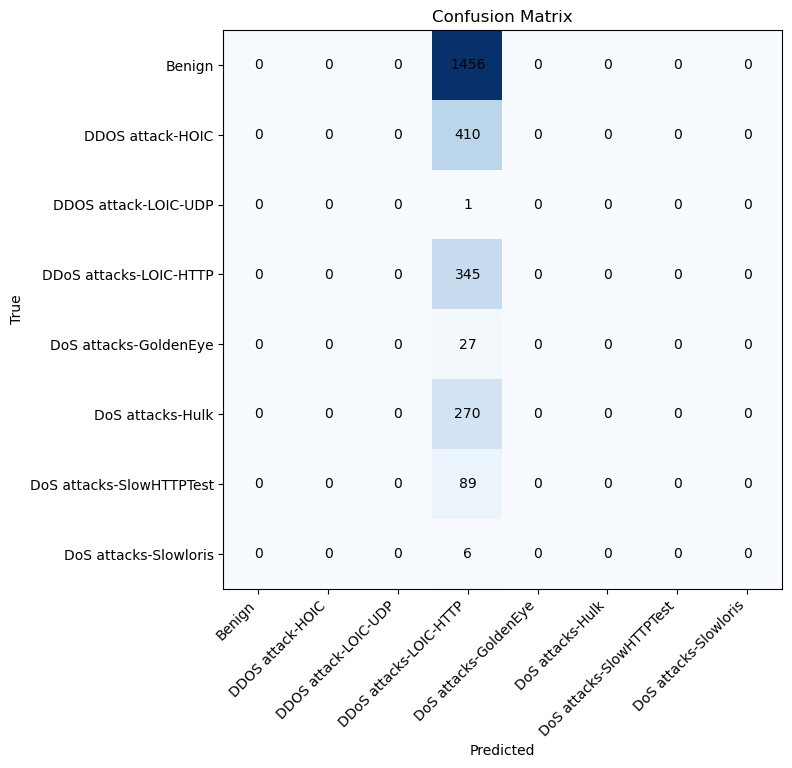

In [ ]:
# ---------------------------
# 6. Evaluation on Test Set
# ---------------------------
from sklearn.metrics import roc_curve, auc as sk_auc
plt.ion()
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        probs = F.softmax(out, dim=1)
        _, preds = torch.max(probs, 1)

        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        if train_ds.num_classes == 2:
            y_prob.extend(probs[:,1].cpu().numpy())
        else:
            y_prob.append(probs.cpu().numpy())

# target names
inv_map = {v:k for k,v in train_ds.label_map.items()}
cls_names = [inv_map[i] for i in range(train_ds.num_classes)]

# 6.1 Classification Report
report = classification_report(y_true, y_pred,
                               target_names=cls_names,
                               digits=4)
print("=== Classification Report ===\n", report)

# 6.2 Confusion Matrix + Plot
cm = confusion_matrix(y_true, y_pred)
print("=== Confusion Matrix ===\n", cm)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
ax.set_xticks(range(train_ds.num_classes))
ax.set_yticks(range(train_ds.num_classes))
ax.set_xticklabels(cls_names, rotation=45, ha="right")
ax.set_yticklabels(cls_names)
for i in range(train_ds.num_classes):
    for j in range(train_ds.num_classes):
        ax.text(j, i, cm[i,j], ha="center", va="center")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()
cm_path = os.path.join(output_folder, "confusion_matrix.png")
plt.savefig(cm_path, bbox_inches="tight")
print("Saved confusion matrix to", cm_path)
plt.show()



Saved multiclass ROC curves to Outputs/2018/2dcnn/2dcnn_run1-0_5pct/roc_curve_multiclass.png


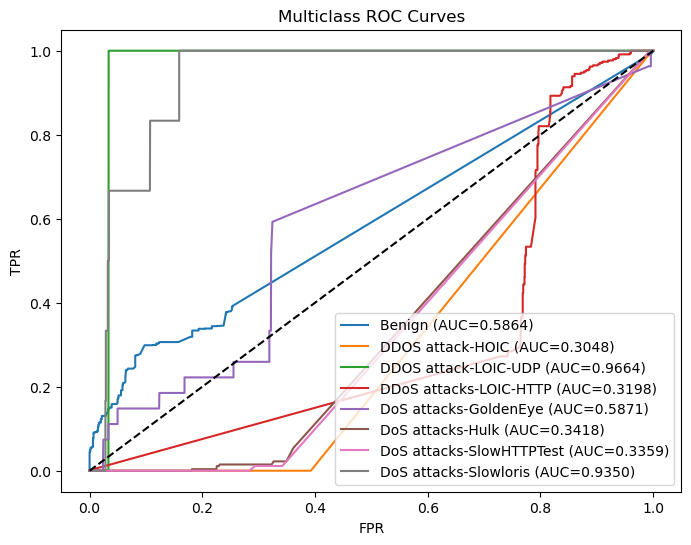

Saved all test metrics to Outputs/2018/2dcnn/2dcnn_run1-0_5pct/test_evaluation_metrics.txt


In [ ]:
# ---------------------------
# 6.3 ROC Curves + AUC
# ---------------------------
from sklearn.metrics import roc_curve, auc as sk_auc

if train_ds.num_classes == 2:
    # Binary ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    binary_auc = sk_auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {binary_auc:.4f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC Curve")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="best")

    roc_path = os.path.join(output_folder, "roc_curve.png")
    plt.savefig(roc_path, bbox_inches="tight")
    print("Saved ROC curve to", roc_path)
    plt.show()

    # Prepare AUCs for saving
    auc_dict = {"Overall": binary_auc}

else:
    # Multiclass ROC
    y_true_bin = label_binarize(y_true, classes=list(range(train_ds.num_classes)))
    probs_arr  = np.vstack(y_prob)

    plt.figure(figsize=(8,6))
    auc_dict = {}
    for i, cls in enumerate(cls_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs_arr[:, i])
        cls_auc = sk_auc(fpr, tpr)
        auc_dict[cls] = cls_auc
        plt.plot(fpr, tpr, label=f"{cls} (AUC={cls_auc:.4f})")

    plt.plot([0,1],[0,1],"k--")
    plt.title("Multiclass ROC Curves")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="best")

    roc_path = os.path.join(output_folder, "roc_curve_multiclass.png")
    plt.savefig(roc_path, bbox_inches="tight")
    print("Saved multiclass ROC curves to", roc_path)
    plt.show()

# ---------------------------
# 6.4 Save all metrics to text file
# ---------------------------
metrics_txt = os.path.join(output_folder, "test_evaluation_metrics.txt")
with open(metrics_txt, "w") as f:
    f.write("=== Classification Report ===\n")
    f.write(report + "\n")
    f.write("=== Confusion Matrix ===\n")
    f.write(str(cm) + "\n\n")

    # Write AUC(s)
    if train_ds.num_classes == 2:
        f.write(f"AUC-ROC: {auc_dict['Overall']:.4f}\n")
    else:
        for cls in cls_names:
            f.write(f"{cls} AUC: {auc_dict[cls]:.4f}\n")

print("Saved all test metrics to", metrics_txt)